In [8]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import sys

# import setGPU
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K

from datetime import datetime
from tensorboard import program
import os
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
from autoencoder_classes import AE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
from losses import mse_split_loss, radius, kl_loss
from functions import make_mse_loss_numpy
from sklearn.metrics import roc_curve, auc


from data_preprocessing import prepare_data
from model import build_AE, build_VAE


def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

In [9]:
input_qcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended/QCD_preprocessed.h5"
input_bsm="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended/BSM_preprocessed.h5"
events = 10000
load_pickle=False
input_pickle='data-for-dnn-v2.pickle'
output_pfile="data.pickle"


if(load_pickle):
    if(input_pickle==''):
        print('Please provide input pickle files')
    with open("data-for-dnn-v2.pickle", 'rb') as f:
        X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler = pickle.load(f)
        bsm_labels=['VectorZPrimeToQQ__M50',
              'VectorZPrimeToQQ__M100',
              'VectorZPrimeToQQ__M200',
              'VBF_HToInvisible_M125',
              'VBF_HToInvisible_M125_private',
              'ZprimeToZH_MZprime1000',
              'ZprimeToZH_MZprime800',
              'ZprimeToZH_MZprime600',
              'GluGluToHHTo4B',
              'HTo2LongLivedTo4mu_1000',
              'HTo2LongLivedTo4mu_125_12',
              'HTo2LongLivedTo4mu_125_25',
              'HTo2LongLivedTo4mu_125_50',
              'VBFHToTauTau',
              'VBF_HH']

else:
    if(input_qcd==''or input_bsm==''):
        print('Please provide input H5 files')
    X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = prepare_data(input_qcd, input_bsm, events, '',True)
    
    if(output_pfile!='' and not load_pickle):
        with open(output_pfile, 'wb') as f:
            pickle.dump([X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels], f)
        print("Saved Pickle data to disk")
        

*** Reading QCD
QCD: (10000, 19, 3)
(5000, 57)
GluGluToHHTo4B : (10000, 19, 3)
HTo2LongLivedTo4mu_1000 : (10000, 19, 3)
HTo2LongLivedTo4mu_125_12 : (10000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (10000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (10000, 19, 3)
VBFHToTauTau : (10000, 19, 3)
VBF_HH : (10000, 19, 3)
VBF_HToInvisible_M125 : (10000, 19, 3)
VBF_HToInvisible_M125_private : (10000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (10000, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (10000, 19, 3)
ZprimeToZH_MZprime600 : (10000, 19, 3)
ZprimeToZH_MZprime800 : (10000, 19, 3)
*** Read BSM Data
reutrned data
Saved Pickle data to disk


In [15]:
model_type='AE'
latent_dim=6
batch_size= 1024
n_epochs = 20

if(model_type=='AE'):
    autoencoder = build_AE(X_train_flatten.shape[-1],latent_dim)
    model = AE(autoencoder)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001))

    callbacks=[]
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
    callbacks.append(TerminateOnNaN())
    callbacks.append(NeptuneMonitor())
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

elif(model_type=='VAE'):
    encoder, decoder = build_VAE(X_train_flatten.shape[-1],latent_dim)
    model = VAE(encoder, decoder)
    model.compile(optimizer=keras.optimizers.Adam())

    callbacks=[]
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
    callbacks.append(TerminateOnNaN())
    callbacks.append(NeptuneMonitor())
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

print("Training the model")

history = model.fit(X_train_flatten, X_train_scaled,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=callbacks)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 57)]              0         
                                                                 
 batch_normalization_10 (Bat  (None, 57)               228       
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 32)                1856      
                                                                 
 batch_normalization_11 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528 

Saved model to disk
Saved history to disk
        loss  val_loss     lr  epoch
15  1.618929  2.175653  0.001     15
16  1.569683  2.064674  0.001     16
17  1.539358  1.970546  0.001     17
18  1.509589  1.892925  0.001     18
19  1.466734  1.822327  0.001     19


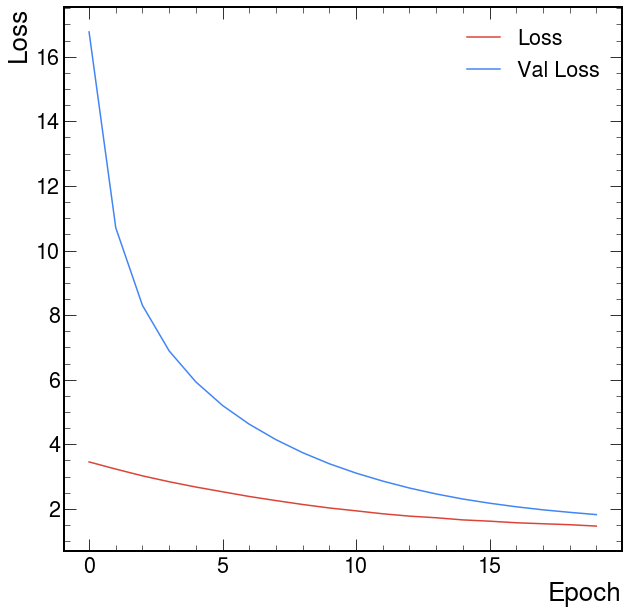

In [16]:
output_model_h5='model.h5'
output_model_json='model.json'
output_history='history.h5'
output_result='results.h5'

if(output_model_h5!=''):
    model_json = autoencoder.to_json()
    with open(output_model_json, 'w') as json_file:
        json_file.write(model_json)
    autoencoder.save_weights(output_model_h5)
    print("Saved model to disk")

if(output_history!=''):
    with open(output_history, 'wb') as f:
        pickle.dump(history.history, f)
    print("Saved history to disk")


# Plot training & validation loss values
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())
plt.plot(hist.index.to_numpy(),hist['loss'],label='Loss')
plt.plot(hist.index.to_numpy(),hist['val_loss'],label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.pdf')
plt.show()

In [17]:
print("Evaluating the model")
loss = make_mse_loss_numpy
qcd_prediction = model.autoencoder(X_test_scaled).numpy()
results={}
min_loss,max_loss=1e5,0
for i, label in enumerate(bsm_labels):
    results[label] = {}
    bsm_pred = model.autoencoder(bsm_data[i]).numpy()
    results[label]['target'] = bsm_target[i]
    results[label]['prediction'] = bsm_pred
    total_loss = return_total_loss(loss, bsm_target[i], bsm_pred)
    if(np.min(total_loss)<min_loss): min_loss = np.min(total_loss)
    if(np.max(total_loss)>max_loss): max_loss = np.max(total_loss)
    results[label]['loss'] = total_loss

results['QCD'] = {}
results['QCD']['target'] = X_test_scaled
results['QCD']['prediction'] = qcd_prediction
results['QCD']['loss'] = return_total_loss(loss, X_test_scaled, qcd_prediction)

Evaluating the model


In [18]:
if(output_result!=''):
    h5f = h5py.File(output_result, 'w')
    h5f.create_dataset('loss', data=hist['loss'].to_numpy())
    h5f.create_dataset('val_loss', data=hist['val_loss'].to_numpy())
    h5f.create_dataset('QCD_input', data=X_test_flatten)
    h5f.create_dataset('QCD_target', data=X_test_scaled)
    h5f.create_dataset('predicted_QCD', data = qcd_prediction)
    for i, key in enumerate(results):
        if(key=='QCD'): continue
        h5f.create_dataset('%s_scaled' %key, data=results[key]['target'])
        h5f.create_dataset('%s_input' %key, data=bsm_data[i])
        h5f.create_dataset('predicted_%s' %key, data=results[key]['prediction'])
    print("*** OutputFile Created")
    h5f.close() 

*** OutputFile Created


Plotting the results


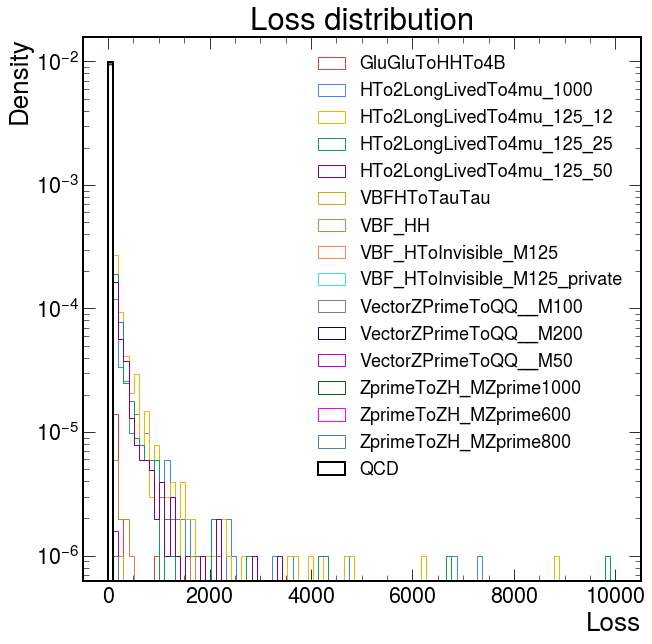

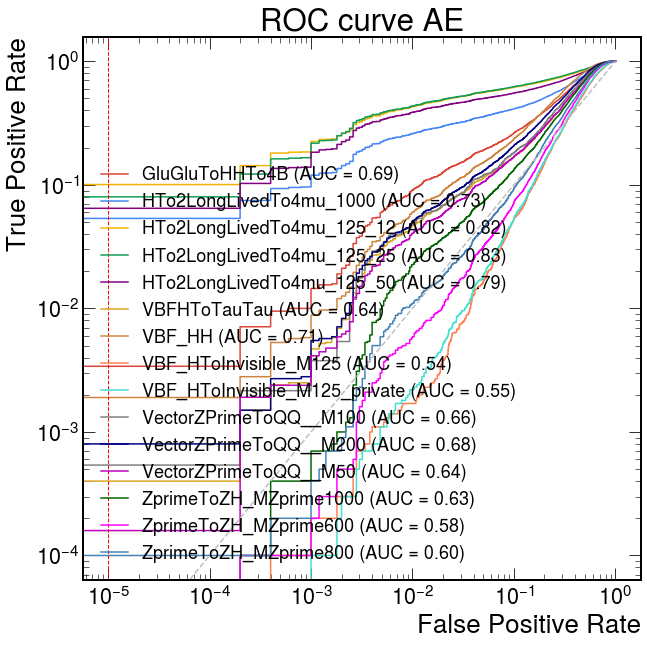

In [19]:
print("Plotting the results")
tag='test'
if(max_loss>10000): max_loss=10000
bins_=np.linspace(min_loss,max_loss,100)
plt.figure(figsize=(10,10))
for key in results.keys():
    if(key=='QCD'): plt.hist(results[key]['loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(results[key]['loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Loss distribution')
plt.savefig('loss_hist_'+model_type+'_'+tag+'.pdf')
plt.show()

plt.figure(figsize=(10,10))
for key in results.keys():
    if key=='QCD': continue

    true_label = np.concatenate(( np.ones(results[key]['target'].shape[0]), np.zeros(results['QCD']['prediction'].shape[0]) ))
    pred_loss = np.concatenate(( results[key]['loss'], results['QCD']['loss'] ))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    plt.plot(fpr_loss, tpr_loss, label='%s (AUC = %0.2f)' %(key,auc_loss))
plt.legend(fontsize='x-small')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
plt.title('ROC curve '+model_type)
plt.xscale('log')
plt.yscale('log')
plt.savefig('roc_curve_'+model_type+'_'+tag+'.pdf')
plt.show()